In [364]:
from velocity_field import vel
from numerical_integrators.single_step import euler, rk2, rk3, rk4
from numerical_integrators.adaptive_step import rkhe21, rkdp54
import matplotlib.pyplot as plt
import numpy as np

In [453]:
t_min, t_max = 0, 5

h = 0.01

h_ref = np.copy(h)

x_min, x_max = 0, 2
y_min, y_max = 0, 1

Ny = 201
Nx = 1 + np.floor((Ny-1)*(x_max-x_min)/(y_max-y_min)).astype(int)

dx = (x_max - x_min)/(Nx - 1)
dy = (y_max - y_min)/(Ny - 1)

In [454]:
x0 = np.linspace(x_min, x_max, Nx)
y0 = np.linspace(y_min, y_max, Ny)

x = np.zeros(Nx*Ny)
y = np.copy(x)

for j in range(Ny):
    x[j*Nx:(j+1)*Nx] = x0
    y[j*Nx:(j+1)*Nx] = y0[j]

pos = np.array([x, y])

print(np.shape(pos))

(2, 80601)


In [455]:
left_offset = np.ones([Ny, Nx])
right_offset = np.copy(left_offset)

top_offset = np.copy(left_offset)
bottom_offset = np.copy(left_offset)

lyap = np.copy(left_offset)

print(np.shape(left_offset))

print(np.shape(pos[0].reshape(Ny,Nx)))

(201, 401)
(201, 401)


In [456]:
n_snaps = 1
t_tot = t_max - t_min
t_incr = t_tot / n_snaps

In [457]:
def timestep(t,            # Current time level
             pos,
             h,            # Timestep
             deriv,        # Function handle for the derivatives,
                           # in our case, the velocity field
             integrator    # Function handle for the numerical
                           # integrator to use, e.g., 'euler' or 'rk4'
             ):

    # All numerical integrators return the following variables:
    #    t:    New time level       (for adaptive timestep integrators,
    #                                the time level is only updated if
    #                                the trial step is accepted)
    #    x:    New coordinate array (for adaptive timestep integrators,
    #                                the coordinates are only updated
    #                                if the trial step(s) is accepted)
    #    h:    Timestep             (subject to change in adaptive
    #                                timestep integrators, otherwise
    #                                unaltered)
    t, pos, h = integrator(t,
                              pos,
                              h,
                              deriv, atol = 1e-5, rtol = 1e-5
                              )
    # We return the new time level, the updated coordinates and
    # the (updated) timestep.
    return t, pos, h

In [458]:
t = t_min
ts = np.ones(Nx*Ny)*t_min

hs = np.ones(np.shape(ts))*h_ref

In [459]:
integrator = rkhe21

In [460]:
# Now, we're ready to step forwards in time:

# First, we loop over the number of snapshots we want to generate:
for i in range(n_snaps):
    # We step forwards in time from one snapshot to the next:
    counter = 0
    while np.any(ts < t_min + (i+1)*t_incr):
        counter+=1
        hs = np.minimum(hs, t_min + (i+1)*t_incr - ts)

        ts, pos, hs = timestep(ts, pos, hs, vel, integrator)
        

    print(counter)
    xy = pos[0].reshape(Ny, Nx)
    yx = pos[1].reshape(Ny, Nx)

    left_offset[1:-2,1:-2] = np.sqrt((xy[0:-3,1:-2]-xy[1:-2,1:-2])**2
                                    +(yx[0:-3,1:-2]-yx[1:-2,1:-2])**2)

    right_offset[1:-2,1:-2] = np.sqrt((xy[2:-1,1:-2]-xy[1:-2,1:-2])**2
                                     +(yx[2:-1,1:-2]-yx[1:-2,1:-2])**2)


    top_offset[1:-2,1:-2] = np.sqrt((xy[1:-2,0:-3]-xy[1:-2,1:-2])**2
                                   +(yx[1:-2,0:-3]-yx[1:-2,1:-2])**2)

    bottom_offset[1:-2,1:-2] = np.sqrt((xy[1:-2,2:-1]-xy[1:-2,1:-2])**2
                                     +(yx[1:-2,2:-1]-yx[1:-2,1:-2])**2)

    lyap = np.fmax(np.log(np.fmax(left_offset,right_offset)
                  /dx)/(t_min+(i+1)*t_incr),
                  np.log(np.fmax(top_offset,bottom_offset)
                  /dy)/(t_min+(i+1)*t_incr)
                  )









997


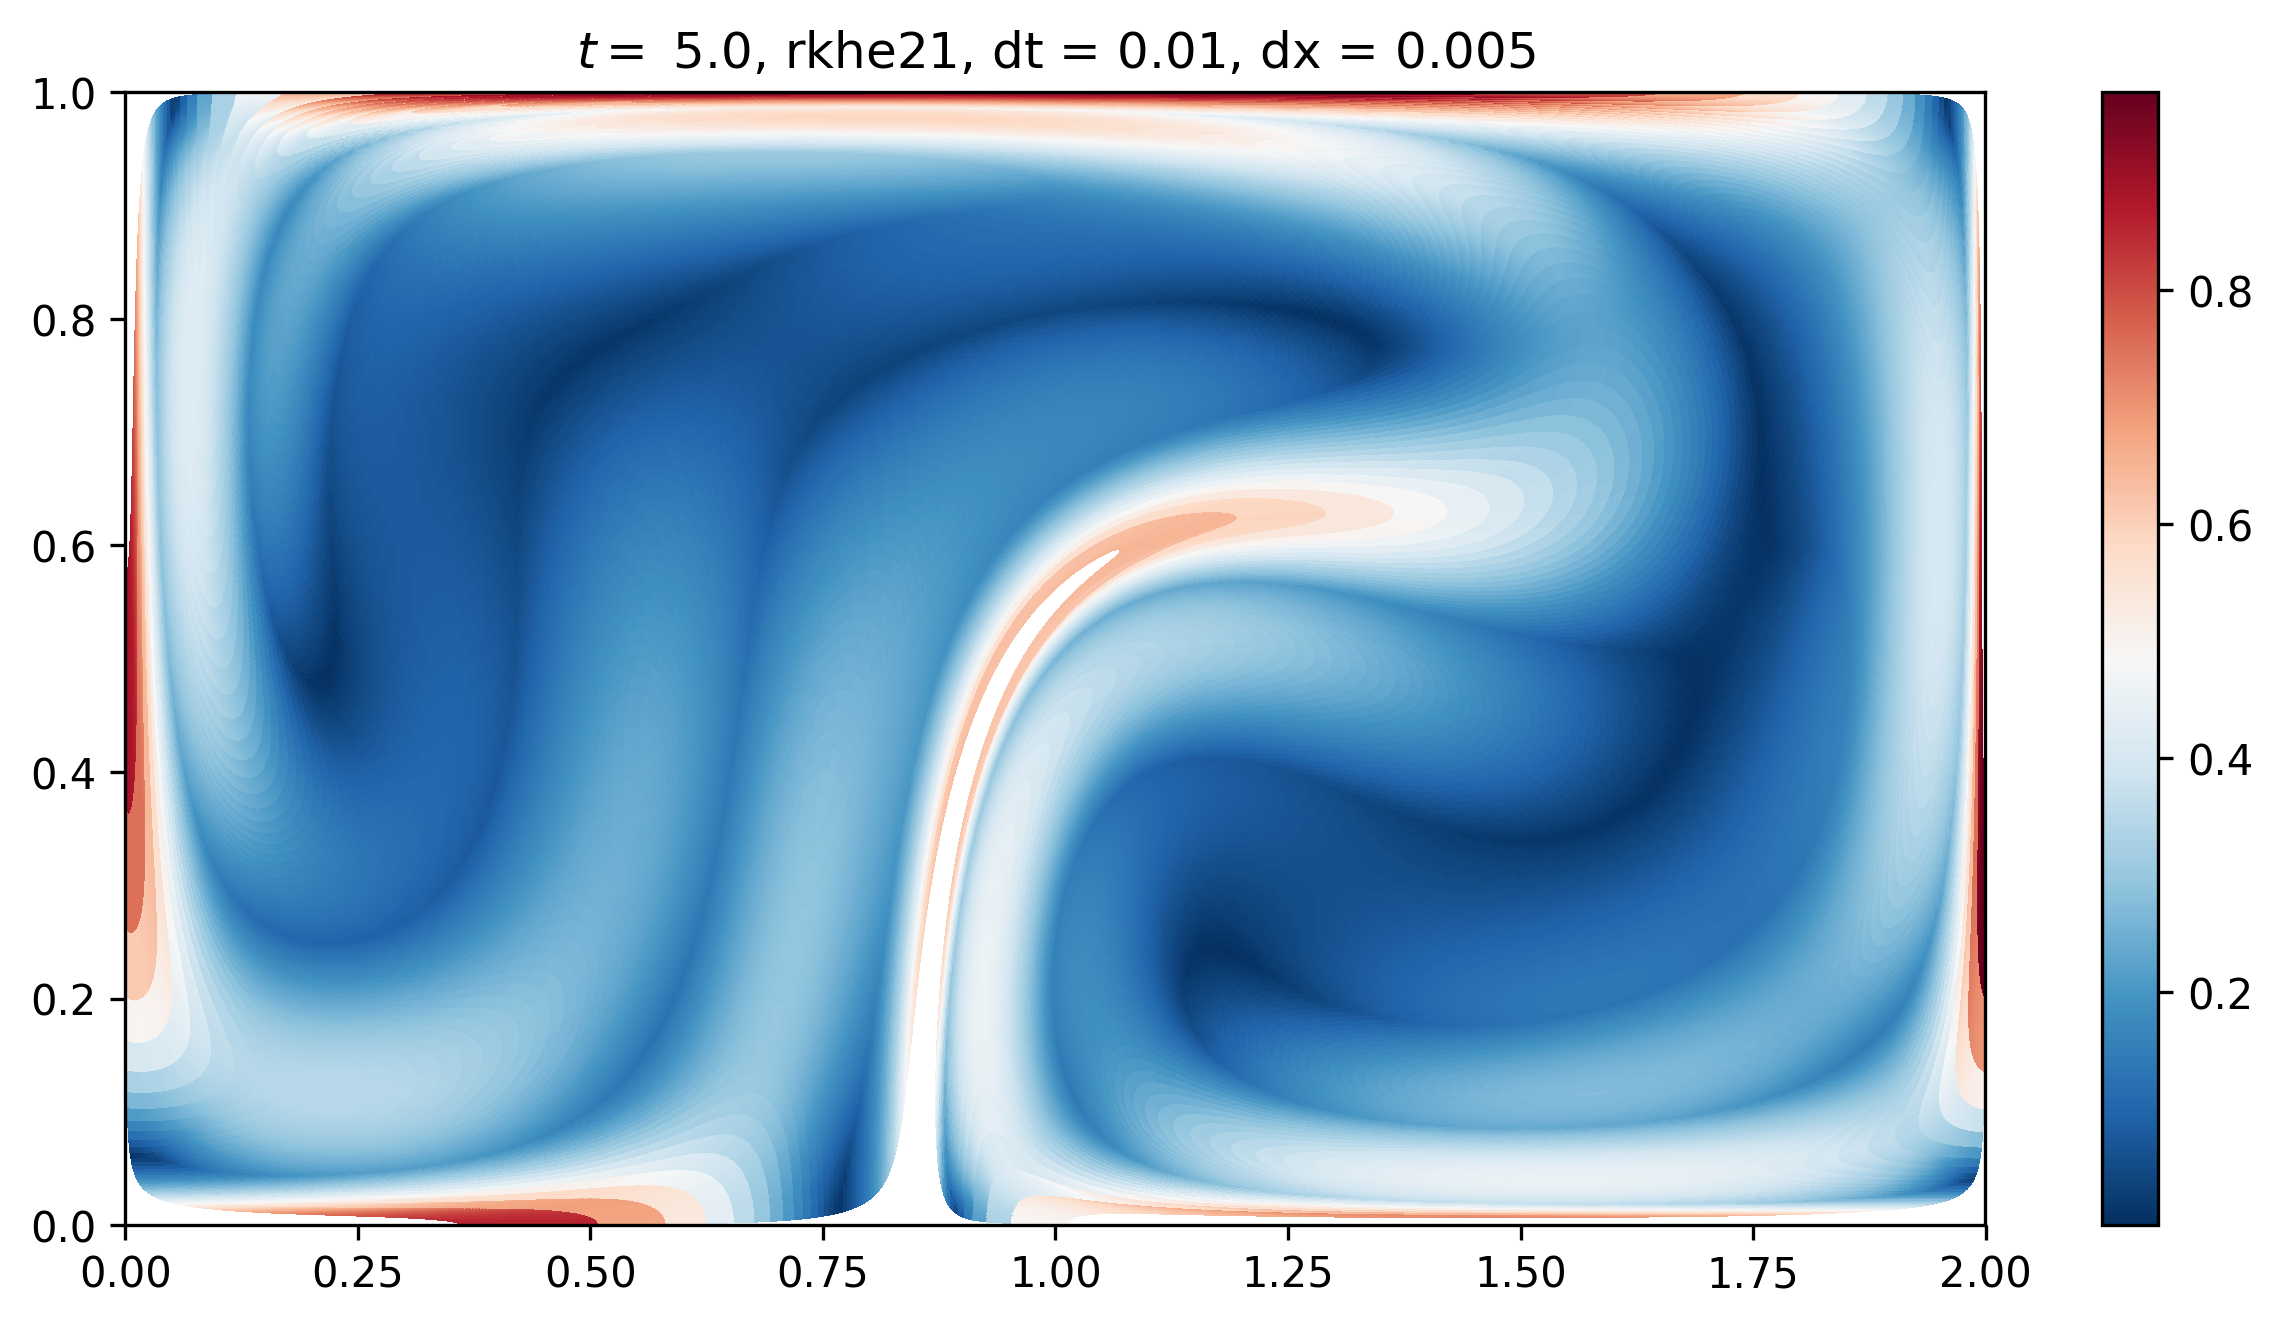

In [462]:
%matplotlib inline    
# Lastly, we need a canvas:
plt.figure(figsize=(10, 5), dpi = 300)
# We plot the calculated FTLE field:
#plt.pcolormesh(xy_ref,yx_ref,lyap,cmap='RdBu_r')
plt.pcolormesh(xy[1:-2,1:-2],1-yx[1:-2,1:-2],  lyap[1:-2,1:-2], cmap='RdBu_r')

plt.colorbar()
plt.title(r'$t=$ {}, {}, dt = {}, dx = {}'.format(t_min + (i+1)*t_incr,
                                                      integrator.__name__,
                                                      h,
                                                      dx
                                                      )
         )


# We clear the canvas, preparing for the next snapshot:
plt.show()

In [382]:
print(np.max(yx))

1.0


In [178]:
a = np.arange(10)

In [179]:
print(a)

[0 1 2 3 4 5 6 7 8 9]


In [180]:
a = np.arange(10, step = -1)

In [181]:
print(a)

[]


In [182]:
b = np.arange(10, 0, step = -1)

In [183]:
print(b)

[10  9  8  7  6  5  4  3  2  1]


In [184]:
a = np.arange(10)

In [185]:
print(np.minimum(a,b))

[0 1 2 3 4 5 4 3 2 1]


In [222]:
print(np.shape(pos))

(2, 66)


In [223]:
print(np.shape(hs))

(66,)


In [224]:
a = tuple(hs, hs)

TypeError: tuple() takes at most 1 argument (2 given)

In [228]:
a = (np.array([hs,]*2))

In [229]:
print(np.size(a))

132


In [235]:
print(np.shape(a[0]))

(66,)


In [236]:
print(np.shape(pos[0]))

(66,)


In [253]:
b = np.concatenate((np.array([hs,]), np.array([hs,])), axis = 0)

In [254]:
print(np.shape(b))

(2, 66)


In [255]:
print(b)

[[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]


In [288]:
yx, xy = np.meshgrid(x0, y0)

In [289]:
print(xy)

[[ 0.     0.     0.    ...,  0.     0.     0.   ]
 [ 0.005  0.005  0.005 ...,  0.005  0.005  0.005]
 [ 0.01   0.01   0.01  ...,  0.01   0.01   0.01 ]
 ..., 
 [ 0.99   0.99   0.99  ...,  0.99   0.99   0.99 ]
 [ 0.995  0.995  0.995 ...,  0.995  0.995  0.995]
 [ 1.     1.     1.    ...,  1.     1.     1.   ]]


In [292]:
print(y.reshape(Ny, Nx))

[[ 0.     0.     0.    ...,  0.     0.     0.   ]
 [ 0.005  0.005  0.005 ...,  0.005  0.005  0.005]
 [ 0.01   0.01   0.01  ...,  0.01   0.01   0.01 ]
 ..., 
 [ 0.99   0.99   0.99  ...,  0.99   0.99   0.99 ]
 [ 0.995  0.995  0.995 ...,  0.995  0.995  0.995]
 [ 1.     1.     1.    ...,  1.     1.     1.   ]]
